In [15]:
# required package versions can be found in requirements_bal.txt

import rushd as rd
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from textwrap import wrap
from statannotations.Annotator import Annotator
from statannot import add_stat_annotation


import warnings
warnings.filterwarnings("ignore",category=UserWarning)
warnings.filterwarnings("ignore",category=FutureWarning)

In [2]:
experimentdir1 = rd.datadir/'instruments'/'data'/'attune'/'Brittany_attune'/'2025.03.24_DIAL' # Rep GibCre for 380bp
experimentdir2 = rd.datadir/'instruments'/'data'/'attune'/'Brittany_attune'/'2025.04.14_DIAL' # Rep modRNA for 380+610bp
experimentdir3 = rd.datadir/'instruments'/'data'/'attune'/'Brittany_attune'/'2025.04.28_DIAL' # Rep modRNA and GibCre for 380bp
experimentdir4 = rd.datadir/'instruments'/'data'/'attune'/'Brittany_attune'/'2025.05.12_DIAL' # 2 Reps of modRNA and GibCre for 380+610bp

outputdir = rd.rootdir/'flow_analysis_scripts'/'2025_DIAL_paper_upload'/'figs_2024_promoter_editing_paper/fig6/'

In [3]:
# rd.plot.plot_well_metadata(experimentdir4/'metadata_controls.yaml')
# rd.plot.plot_well_metadata(experimentdir4/'metadata_GibCre_RepA.yaml')
# rd.plot.plot_well_metadata(experimentdir4/'metadata_modRNA_RepA.yaml')


# Load Data

In [3]:
data_columns = ['CTFR-A','GFP-A','mCherry-A','TagBFP-A']

# 2025.03.24 Rep of GibCre for 380bp
df1 = rd.flow.load_csv_with_metadata(data_path=experimentdir1/'csv_14dpi',yaml_path=experimentdir1/'metadata_v2.yaml',columns=data_columns)
df1['rep'] = '2025.03.24'
df1 = df1[~df1.ZF.isin(['Halo-ZF37-ctlr','Halo Stain','Halo Ligand Only'])] # Get rid of unnecessary conditions

# 2025.04.14 Rep of modRNA for 380+610bp
df2 = rd.flow.load_csv_with_metadata(data_path=experimentdir2/'csv_14dpi_PGK',yaml_path=experimentdir2/'metadata_PGK_v2.yaml',columns=data_columns)
df2['rep'] = '2025.04.14'

# 2025.4.28 Rep of modRNA and GibCre for 380bp
df3a = rd.flow.load_csv_with_metadata(data_path=experimentdir3/'csv_14dpi_mCh-RAS_modRNA',yaml_path=experimentdir3/'metadata_mCh-RAS_modRNA.yaml',columns=data_columns)
df3b = rd.flow.load_csv_with_metadata(data_path=experimentdir3/'csv_14dpi_mCh-RAS_GibCre',yaml_path=experimentdir3/'metadata_mCh-RAS_GibCre.yaml',columns=data_columns)
df3 = pd.concat([df3a,df3b])
df3['rep'] = '2025.04.28'

# 2 Reps of modRNA and GibCre for 380+610bp
df4a = rd.flow.load_csv_with_metadata(data_path=experimentdir4/'csv_14dpi_modRNA_RepA',yaml_path=experimentdir4/'metadata_modRNA_RepA.yaml',columns=data_columns)
df4b = rd.flow.load_csv_with_metadata(data_path=experimentdir4/'csv_14dpi_modRNA_RepB',yaml_path=experimentdir4/'metadata_modRNA_RepB.yaml',columns=data_columns)
df4c = rd.flow.load_csv_with_metadata(data_path=experimentdir4/'csv_14dpi_GibCre_RepA',yaml_path=experimentdir4/'metadata_GibCre_RepA.yaml',columns=data_columns)
df4d = rd.flow.load_csv_with_metadata(data_path=experimentdir4/'csv_14dpi_GibCre_RepB',yaml_path=experimentdir4/'metadata_GibCre_RepB.yaml',columns=data_columns)
df4 = pd.concat([df4a,df4b,df4c,df4d])

df = pd.concat([df1,df2,df3,df4])


Make condition names

In [4]:
df['condition_all'] = df['reporter'] + ' ' + df['ZF'] + ' ' + df['cre'] + ' ' + df['gib']+ ' ' + df['reprogramming']
df['cre, gib'] = df['cre'] + ', ' + df['gib']
df['ZF, cre'] = df['ZF'] + ', ' + df['cre']
df['ZF, cre, gib'] = df['ZF'] + ', ' + df['cre'] + ', ' + df['gib']
df['reporter, ZF, cre, gib'] = df['reporter'] + ', ' + df['ZF'] + ', ' + df['cre'] + ', ' + df['gib']
df['reporter, ZF, cre'] = df['reporter'] + ', ' + df['ZF'] + ', ' + df['cre']

Get rid of negative values

In [5]:
df = df.astype({'GFP-A': 'float64', 'TagBFP-A': 'float64','mCherry-A':'float64','CTFR-A':'float64'}) # for some reason I'm having unusual trouble with datatypes and this fixes it

for i in np.arange(0,np.size(data_columns)):
    df = df.loc[df[data_columns[i]]>0]


# Gating

## iMN gate

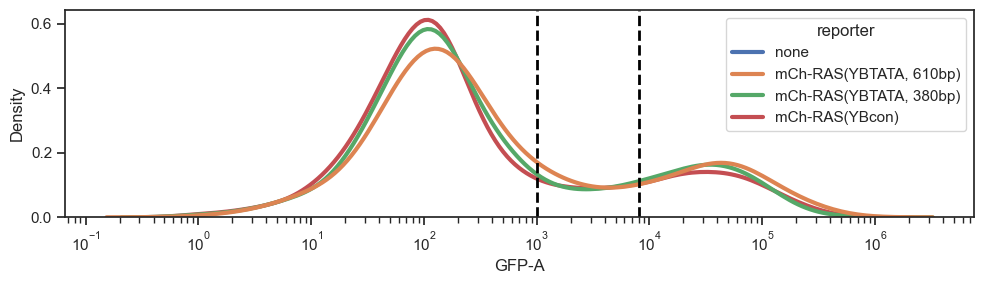

In [8]:
iMN_gate = 8 * 10**3 # Set gate
GFP_gate = 1 * 10**3

sns.set_theme(style="ticks",font_scale=1)

condition_list = ['none','mCh-RAS(YBTATA, 610bp)','mCh-RAS(YBTATA, 380bp)','mCh-RAS(YBcon)']
slice = df[( (df['reporter'].isin(condition_list)) & (df['ZF'] == 'No ZF') ) | (df['reporter'] == 'none') ]

# Plot gate
plt.figure(figsize=(10,3))
g = sns.kdeplot(data=slice.sample(10000),x='GFP-A',hue='reporter',log_scale=True,common_norm=False,linewidth=3,hue_order=condition_list)
plt.axvline(x=iMN_gate,linestyle='--',color='black',linewidth=2)
plt.axvline(x=GFP_gate,linestyle='--',color='black',linewidth=2)

#sns.move_legend(g, loc='upper left', bbox_to_anchor=(1,1), frameon=False)
plt.tight_layout()
plt.show()

# Plotting Functions

In [ ]:
sns.set_theme(style="ticks",font='Arial',font_scale=1)
plt.rcParams['font.family'] = 'Arial'

def SK_dotplot( x, y, hue, data,pairs=[], palette = 'muted', order=None, hue_order =None, plottitle="",savetitle = '',
                 save_fig=False, dodge=True,x_rot=0, scientific=True,yscale="linear",y_ax_k=False, stat_text = 'star', 
                 ylim=False,aspect=None, plot_reps=True, join=False,
                 xlabel = 'Default', ylabel = 'Default', legend=True, xticklabels=True,
                 type = 'pointplot', figsize = None, markers='o', pointplot_settings='old',
                 fontsize=False, axis_lines={'top': False, 'bottom': True, 'left': True, 'right': False},capsize=True,subfolder=False):


        if aspect != None:
            g, ax = plt.subplots()
            ax.set_box_aspect(aspect)
            #plt.rc('ytick', labelsize=15) 
        if figsize != None:
            plt.figure(figsize=figsize)

        #plot all of the replicates of each condtion
        if plot_reps == True:
            g = sns.stripplot(data=data, x=x, y=y,hue=hue, dodge=dodge, alpha=0.2, palette=palette,size=4,hue_order=hue_order, order=order)

        #Add in the means 
        #sns.barplot(x="reporter", y="eGFP-A_gmean",hue='rec', data=s, estimator=np.mean,capsize=.1,alpha=0.2,errwidth=2,errcolor='gray')
        if dodge == True and hue is not None:
            n_hue_levels = len(data[hue].unique())
            if n_hue_levels > 1:
                dodge_amt = 0.5
            else:
                dodge_amt = False
        elif dodge == True and hue is None:
            dodge_amt = 0.5
        else:
            dodge_amt = False

        if type == 'pointplot':
            if pointplot_settings == 'new':
                g = sns.pointplot(x=x, y=y,hue=hue, data=data, estimator=np.mean, 
                            errorbar='se', capsize=0,errwidth=0.75, join=join,scale=0.75, dodge = dodge_amt , 
                            palette=palette,hue_order=hue_order, order=order, markers=markers)
            #Old pointpolt settings
            if pointplot_settings == 'old':
                g = sns.pointplot(x=x, y=y,hue=hue, data=data, estimator=np.mean, 
                    errorbar='se', capsize=.18,errwidth=.75, join=join, markers=markers,scale=.75, dodge = dodge_amt , 
                    palette=palette,hue_order=hue_order, order=order)
            
            if legend==False:
                g.get_legend().remove()
             

        if type == 'barplot':
            g = sns.barplot(x=x, y=y, hue=hue, data=data, estimator=np.mean,
                            errorbar='se', capsize=.1,errwidth=1, dodge = dodge_amt , 
                    palette=palette, hue_order=hue_order, order=order, alpha = 0.7,markers=markers)
        
        
        if (legend==True and hue != None):
            leg = g.legend(title="Condition", loc="upper left",
               bbox_to_anchor=(1, 1), frameon=False)
    
        
        #rotate the x-labels
        # labels = g.get_xticklabels()
        if order != None:
            if '(' in order[0]:
                labels = [ '\n('.join(l.split('(')) for l in order]
                labels = [ '\n'.join(l.split(' ')) for l in labels]
            else:
                labels = [ '\n'.join(l.split(',')) for l in order]
        if xticklabels == False:
            labels = []
        g.set_xticklabels(labels=labels, rotation=x_rot, horizontalalignment='center' if x_rot==0 else 'right')



        #set the y-scale
        plt.yscale(yscale)

        #Set ylim
        ax=plt.gca()
        if ylim != False:
            ax.set_ylim(ymin=ylim[0], ymax=ylim[1])

        #make scientific axes 
        if scientific != False:
            if yscale == "linear":
                plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

        ymin, ymax = ax.get_ylim()
        if y_ax_k != False and ymax>1000:
            k_formatter = matplotlib.ticker.FuncFormatter(lambda x, _: f'{x:.0f}' if abs(x) < 1000 else f'{x/1000:.0f}k')
            ax.yaxis.set_major_formatter(k_formatter)

        #Add in the T-tests
        if len(pairs)>0:
            add_stat_annotation(g, data=data, x=x, y=y,hue=hue,
                        box_pairs=pairs, order=order, hue_order=hue_order,
                        test='t-test_ind', text_format=stat_text, loc='inside', verbose=2, 
                        comparisons_correction= None)
        
        #set x-label and y-label 
        xl = xlabel; yl = ylabel; 
        if xlabel == 'Default': 
             xl = x
        if ylabel == 'Default': 
             yl = y
        plt.xlabel(xl)  # Adjust x-axis label
        plt.ylabel(yl)  # Adjust y-axis label

        if fontsize != False: 
            g.set_xlabel(xl, fontsize=fontsize)  # Adjust the font size of x-axis label
            g.set_ylabel(yl, fontsize=fontsize)  # Adjust the font size of y-axis label
            #set ticks 
            g.tick_params(axis='both', labelsize=fontsize,length=5)  # Adjust the font size of tick labels and tick lengths

        plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.25) # make all plots have the same area

        plt.title(plottitle)
        g.spines['top'].set_visible(True)
        g.spines['right'].set_visible(True)
        g.spines['bottom'].set_visible(True)
        g.spines['left'].set_visible(True)

        if not axis_lines['top']:
            g.spines['top'].set_visible(False)
        if not axis_lines['right']:
            g.spines['right'].set_visible(False)
        if not axis_lines['bottom']:
            g.spines['bottom'].set_visible(False)
        if not axis_lines['left']:
            g.spines['left'].set_visible(False)
        
        plt.show(g)

        # adjust figure size to accommodate all axes decorations
        plt.tight_layout()

        #save figure
       
        h = g.get_figure()
        if save_fig==True:
                if subfolder == False:
                    h.savefig(outputdir/str(savetitle + '.svg'),dpi=300)
                else:
                    h.savefig(outputdir/subfolder/str(savetitle + '.svg'),dpi=300)
        return g


# Summary Stats - All Cells

In [10]:
groups = ['rep','reprogramming','reporter','ZF','cre','gib','well','condition_all',
          'cre, gib','ZF, cre','ZF, cre, gib','reporter, ZF, cre, gib','reporter, ZF, cre'] # 'rep' must be first group!!!!

# Create the summary dataframe
summary_df = pd.concat([
    df.groupby(groups)['GFP-A'].apply(lambda x: np.size(x)).rename('Total Cell Count'),
    df.groupby(groups)['mCherry-A'].apply(scipy.stats.gmean).rename('mCherry MFI'),
    df.loc[df['GFP-A']>iMN_gate].groupby(groups)['mCherry-A'].apply(scipy.stats.gmean).rename('mCherry MFI (iMNs)'),
    df.loc[df['GFP-A']<iMN_gate].groupby(groups)['mCherry-A'].apply(scipy.stats.gmean).rename('mCherry MFI (non-iMNs)'),
    df.loc[df['GFP-A']<GFP_gate].groupby(groups)['mCherry-A'].apply(scipy.stats.gmean).rename('mCherry MFI (GFP-neg)'),
    df.groupby(groups)['GFP-A'].apply(lambda x: np.mean(x > iMN_gate)*100).rename('(%) iMN\nof all cells'),
    df.groupby(groups)['GFP-A'].apply(lambda x: np.sum(x > iMN_gate)).rename('iMN Yield'),
    df.groupby(groups)['GFP-A'].apply(lambda x: np.sum(x > iMN_gate)/5000 * 100).rename('(%) iMN yield\nper MEF plated')
], axis=1)
summary_df = summary_df.reset_index()

In [ ]:
summary_df = summary_df[(summary_df.rep != '2025.04.14')] # drop this modRNA rep due to unusually low cell counts

# rep '2025.04.14' excluded due to MEF batch viability issues based on low cell counts at 5 dpi compared to historical results
# most likely due to batch preparation and extraction 

In [12]:
bar2plot = ['Total Cell Count','(%) iMN\nof all cells','(%) iMN yield\nper MEF plated']
dot2plot = ['mCherry MFI','mCherry MFI (iMNs)','mCherry MFI (GFP-neg)']

savedict = {'mCherry MFI':'mCherry MFI',
            'Total Cell Count':'Total Cell Count',
            '(%) iMN\nof all cells':'(%) iMN of all cells',
            '(%) iMN yield\nper MEF plated':'(%) iMN yield per MEF plated',
            '(%) iMN\nof ZF+':'(%) iMN of ZF+',
            '(#) ZF+ Cells':'(#) ZF+ Cells',
            '(%) iMN of ZF+ cells':'(%) iMN of ZF+ cells',
            'iMN Yield':'iMN Yield',
            '(%) HyperP':'(%) HyperP','(#) Total HyperP':'(#) Total HyperP',
            'mCh-RAS(YBcon)':'YBcon',
            'mCh-RAS(YBTATA, 380bp)':'380bp',
            'mCh-RAS(YBTATA, 610bp)':'610bp',
            'mCherry MFI (iMNs)':'mCherry MFI (iMNs)',
            'mCherry MFI (non-iMNs)':'mCherry MFI (non-iMNs)',
            'mCherry MFI (GFP-neg)':'mCherry MFI (GFP-neg)'}

ylabel_dict = {'mCherry MFI':'Output gmean (mCherry)','mCherry MFI (iMNs)':'Output gmean (mCherry)',
               'mCherry MFI (non-iMNs)':'Output gmean (mCherry)','mCherry MFI (GFP-neg)':'Output gmean (mCherry)'}



# Plot results for all cells

## modRNA Results

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

mCh-RAS(YBcon)_No ZF, NoCre v.s. mCh-RAS(YBcon)_PGK-ZF37-BFP, modeeBxb1: t-test independent samples, P_val=6.653e-21 stat=-2.078e+01
mCh-RAS(YBcon)_PGK-ZF37-BFP, modeeBxb1 v.s. mCh-RAS(YBcon)_PGK-ZF37-BFP, modPuroCre: t-test independent samples, P_val=1.534e-01 stat=1.460e+00


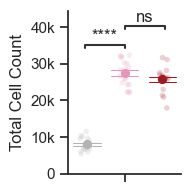

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

mCh-RAS(YBcon)_No ZF, NoCre v.s. mCh-RAS(YBcon)_PGK-ZF37-BFP, modeeBxb1: t-test independent samples, P_val=2.949e-04 stat=-4.033e+00
mCh-RAS(YBcon)_PGK-ZF37-BFP, modeeBxb1 v.s. mCh-RAS(YBcon)_PGK-ZF37-BFP, modPuroCre: t-test independent samples, P_val=5.475e-01 stat=6.076e-01


<Figure size 640x480 with 0 Axes>

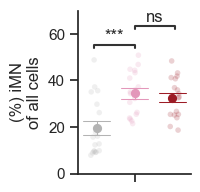

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

mCh-RAS(YBcon)_No ZF, NoCre v.s. mCh-RAS(YBcon)_PGK-ZF37-BFP, modeeBxb1: t-test independent samples, P_val=1.053e-14 stat=-1.295e+01
mCh-RAS(YBcon)_PGK-ZF37-BFP, modeeBxb1 v.s. mCh-RAS(YBcon)_PGK-ZF37-BFP, modPuroCre: t-test independent samples, P_val=1.885e-01 stat=1.342e+00


<Figure size 640x480 with 0 Axes>

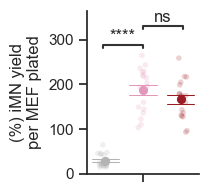

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

mCh-RAS(YBcon)_No ZF, NoCre v.s. mCh-RAS(YBcon)_PGK-ZF37-BFP, modeeBxb1: t-test independent samples, P_val=3.836e-14 stat=-1.237e+01
mCh-RAS(YBcon)_PGK-ZF37-BFP, modeeBxb1 v.s. mCh-RAS(YBcon)_PGK-ZF37-BFP, modPuroCre: t-test independent samples, P_val=8.802e-01 stat=1.519e-01


<Figure size 640x480 with 0 Axes>

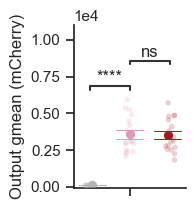

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

mCh-RAS(YBcon)_No ZF, NoCre v.s. mCh-RAS(YBcon)_PGK-ZF37-BFP, modeeBxb1: t-test independent samples, P_val=3.073e-15 stat=-1.352e+01
mCh-RAS(YBcon)_PGK-ZF37-BFP, modeeBxb1 v.s. mCh-RAS(YBcon)_PGK-ZF37-BFP, modPuroCre: t-test independent samples, P_val=8.029e-01 stat=2.516e-01


<Figure size 640x480 with 0 Axes>

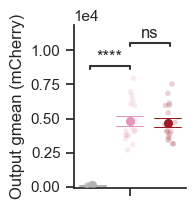

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

mCh-RAS(YBTATA, 380bp)_No ZF, NoCre v.s. mCh-RAS(YBTATA, 380bp)_PGK-ZF37-BFP, modeeBxb1: t-test independent samples, P_val=4.078e-10 stat=-8.658e+00
mCh-RAS(YBTATA, 380bp)_PGK-ZF37-BFP, modeeBxb1 v.s. mCh-RAS(YBTATA, 380bp)_PGK-ZF37-BFP, modPuroCre: t-test independent samples, P_val=8.027e-02 stat=-1.803e+00


<Figure size 640x480 with 0 Axes>

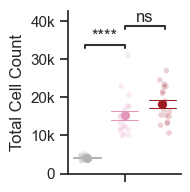

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

mCh-RAS(YBTATA, 380bp)_No ZF, NoCre v.s. mCh-RAS(YBTATA, 380bp)_PGK-ZF37-BFP, modeeBxb1: t-test independent samples, P_val=7.546e-01 stat=3.151e-01
mCh-RAS(YBTATA, 380bp)_PGK-ZF37-BFP, modeeBxb1 v.s. mCh-RAS(YBTATA, 380bp)_PGK-ZF37-BFP, modPuroCre: t-test independent samples, P_val=8.025e-02 stat=-1.803e+00


<Figure size 640x480 with 0 Axes>

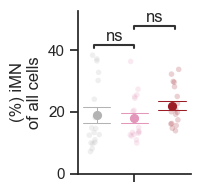

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

mCh-RAS(YBTATA, 380bp)_No ZF, NoCre v.s. mCh-RAS(YBTATA, 380bp)_PGK-ZF37-BFP, modeeBxb1: t-test independent samples, P_val=4.994e-10 stat=-8.584e+00
mCh-RAS(YBTATA, 380bp)_PGK-ZF37-BFP, modeeBxb1 v.s. mCh-RAS(YBTATA, 380bp)_PGK-ZF37-BFP, modPuroCre: t-test independent samples, P_val=3.801e-04 stat=-3.944e+00


<Figure size 640x480 with 0 Axes>

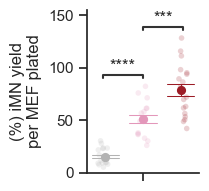

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

mCh-RAS(YBTATA, 380bp)_No ZF, NoCre v.s. mCh-RAS(YBTATA, 380bp)_PGK-ZF37-BFP, modeeBxb1: t-test independent samples, P_val=4.728e-14 stat=-1.228e+01
mCh-RAS(YBTATA, 380bp)_PGK-ZF37-BFP, modeeBxb1 v.s. mCh-RAS(YBTATA, 380bp)_PGK-ZF37-BFP, modPuroCre: t-test independent samples, P_val=1.549e-07 stat=-6.577e+00


<Figure size 640x480 with 0 Axes>

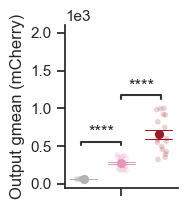

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

mCh-RAS(YBTATA, 380bp)_No ZF, NoCre v.s. mCh-RAS(YBTATA, 380bp)_PGK-ZF37-BFP, modeeBxb1: t-test independent samples, P_val=6.334e-15 stat=-1.319e+01
mCh-RAS(YBTATA, 380bp)_PGK-ZF37-BFP, modeeBxb1 v.s. mCh-RAS(YBTATA, 380bp)_PGK-ZF37-BFP, modPuroCre: t-test independent samples, P_val=7.172e-08 stat=-6.838e+00


<Figure size 640x480 with 0 Axes>

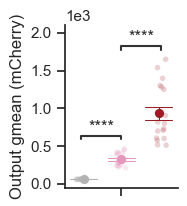

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

mCh-RAS(YBTATA, 610bp)_No ZF, NoCre v.s. mCh-RAS(YBTATA, 610bp)_PGK-ZF37-BFP, modeeBxb1: t-test independent samples, P_val=1.127e-09 stat=-1.004e+01
mCh-RAS(YBTATA, 610bp)_PGK-ZF37-BFP, modeeBxb1 v.s. mCh-RAS(YBTATA, 610bp)_PGK-ZF37-BFP, modPuroCre: t-test independent samples, P_val=9.083e-02 stat=-1.769e+00


<Figure size 640x480 with 0 Axes>

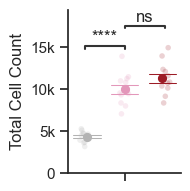

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

mCh-RAS(YBTATA, 610bp)_No ZF, NoCre v.s. mCh-RAS(YBTATA, 610bp)_PGK-ZF37-BFP, modeeBxb1: t-test independent samples, P_val=4.217e-03 stat=3.191e+00
mCh-RAS(YBTATA, 610bp)_PGK-ZF37-BFP, modeeBxb1 v.s. mCh-RAS(YBTATA, 610bp)_PGK-ZF37-BFP, modPuroCre: t-test independent samples, P_val=3.949e-02 stat=-2.189e+00


<Figure size 640x480 with 0 Axes>

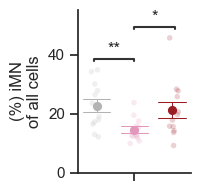

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

mCh-RAS(YBTATA, 610bp)_No ZF, NoCre v.s. mCh-RAS(YBTATA, 610bp)_PGK-ZF37-BFP, modeeBxb1: t-test independent samples, P_val=1.962e-03 stat=-3.513e+00
mCh-RAS(YBTATA, 610bp)_PGK-ZF37-BFP, modeeBxb1 v.s. mCh-RAS(YBTATA, 610bp)_PGK-ZF37-BFP, modPuroCre: t-test independent samples, P_val=1.189e-02 stat=-2.742e+00


<Figure size 640x480 with 0 Axes>

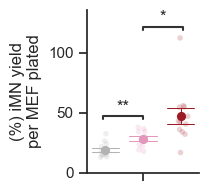

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

mCh-RAS(YBTATA, 610bp)_No ZF, NoCre v.s. mCh-RAS(YBTATA, 610bp)_PGK-ZF37-BFP, modeeBxb1: t-test independent samples, P_val=4.518e-13 stat=-1.506e+01
mCh-RAS(YBTATA, 610bp)_PGK-ZF37-BFP, modeeBxb1 v.s. mCh-RAS(YBTATA, 610bp)_PGK-ZF37-BFP, modPuroCre: t-test independent samples, P_val=5.395e-05 stat=-4.990e+00


<Figure size 640x480 with 0 Axes>

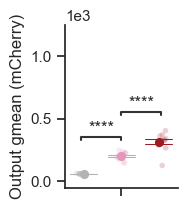

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

mCh-RAS(YBTATA, 610bp)_No ZF, NoCre v.s. mCh-RAS(YBTATA, 610bp)_PGK-ZF37-BFP, modeeBxb1: t-test independent samples, P_val=2.240e-11 stat=-1.236e+01
mCh-RAS(YBTATA, 610bp)_PGK-ZF37-BFP, modeeBxb1 v.s. mCh-RAS(YBTATA, 610bp)_PGK-ZF37-BFP, modPuroCre: t-test independent samples, P_val=3.152e-05 stat=-5.213e+00


<Figure size 640x480 with 0 Axes>

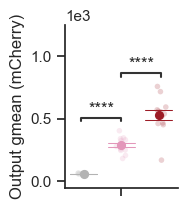

<Figure size 640x480 with 0 Axes>

In [18]:
# modRNA results, mCh-RAS
bar2plot = ['Total Cell Count','(%) iMN\nof all cells','(%) iMN yield\nper MEF plated']
dot2plot = ['mCherry MFI','mCherry MFI (iMNs)']
order = ['mCh-RAS(YBcon)','mCh-RAS(YBTATA, 380bp)','mCh-RAS(YBTATA, 610bp)']
hue_order = ['No ZF, NoCre','PGK-ZF37-BFP, modeeBxb1','PGK-ZF37-BFP, modPuroCre']
palette = { 'No ZF, NoCre':'#b3b3b3', 'PGK-ZF37-BFP, modeeBxb1':'#E397BA', 'PGK-ZF37-BFP, modPuroCre':'#9C1C26'}

pairs = [(('mCh-RAS(YBcon)', 'PGK-ZF37-BFP, modeeBxb1'),('mCh-RAS(YBcon)','PGK-ZF37-BFP, modPuroCre')),
          (('mCh-RAS(YBTATA, 380bp)', 'PGK-ZF37-BFP, modeeBxb1'),('mCh-RAS(YBTATA, 380bp)','PGK-ZF37-BFP, modPuroCre')),
          (('mCh-RAS(YBTATA, 610bp)', 'PGK-ZF37-BFP, modeeBxb1'),('mCh-RAS(YBTATA, 610bp)','PGK-ZF37-BFP, modPuroCre'))]

MFI_ylim_modRNA = {'mCh-RAS(YBcon)':[-50,1.1*10**4],'mCh-RAS(YBTATA, 380bp)':[-50,2.1*10**3],'mCh-RAS(YBTATA, 610bp)':[-50,1.25*10**3]}

for reporter in order:
    pairs = [((reporter,'No ZF, NoCre'),(reporter,'PGK-ZF37-BFP, modeeBxb1')),
             ((reporter,'PGK-ZF37-BFP, modeeBxb1'),(reporter,'PGK-ZF37-BFP, modPuroCre'))]
    for y in bar2plot:
        slice = summary_df[(summary_df['reporter']==reporter) & (summary_df['ZF'].isin(['No ZF','PGK-ZF37-BFP'])) & (summary_df['gib'] == 'none')]
        savetitle = '14dpi_modRNA_' + savedict[reporter] + '_' + savedict[y]
        # custom_barplot('reporter',y,slice,savetitle,
        #                 hue = 'ZF, cre',
        #                 hue_order=hue_order,
        #                 height=2.5,
        #                 width=2,
        #                 order=[reporter],
        #                 palette=palette,reps='rep',xlabel_rot=0,
        #                 pairs=pairs,subfolder='14dpi_all_reps',
        #                 xticklabels=False,legend=False)
        SK_dotplot(x='reporter',y=y,hue='ZF, cre',data=slice,
                   pairs=pairs,palette=palette,order=[reporter],hue_order=hue_order,
                   savetitle=savetitle,save_fig=True,figsize=[1.5,2.5],xlabel=None,subfolder='14dpi_all_reps',
                   legend=False,xticklabels=False,y_ax_k=True,scientific=False,ylim=[0,None])

    for y in dot2plot:
        slice = summary_df[(summary_df['reporter']==reporter) & (summary_df.ZF.isin(['No ZF','PGK-ZF37-BFP'])) & (summary_df['gib'] == 'none')]
        savetitle = '14dpi_modRNA_' + savedict[reporter] + '_' + savedict[y]
        # custom_catplot('reporter',y,slice,savetitle,
        #                 plottitle=plottitle,
        #                 hue = 'ZF, cre',
        #                 hue_order=hue_order,
        #                 height=2.5,
        #                 width=2,
        #                 order=[reporter],
        #                 palette=palette,log=False,errorbar=False,reps='rep',sci=True,xlabel_rot=0,
        #                 pairs=pairs,size=8,subfolder='14dpi_all_reps')
        SK_dotplot(x='reporter',y=y,hue='ZF, cre',data=slice,
                   pairs=pairs,palette=palette,order=[reporter],hue_order=hue_order,
                   savetitle=savetitle,save_fig=True,figsize=[1.5,2.5],xlabel=None,subfolder='14dpi_all_reps',
                   legend=False,xticklabels=False,ylabel=ylabel_dict[y],ylim=MFI_ylim_modRNA[reporter])


## GibCre Results

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

mCh-RAS(YBcon)_No ZF, GibCre, vehicle v.s. mCh-RAS(YBcon)_PGK-ZF37-BFP, GibCre, vehicle: t-test independent samples, P_val=1.582e-15 stat=-1.262e+01
mCh-RAS(YBcon)_PGK-ZF37-BFP, GibCre, vehicle v.s. mCh-RAS(YBcon)_PGK-ZF37-BFP, GibCre, +Gib: t-test independent samples, P_val=5.701e-01 stat=5.726e-01


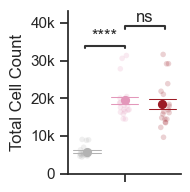

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

mCh-RAS(YBcon)_No ZF, GibCre, vehicle v.s. mCh-RAS(YBcon)_PGK-ZF37-BFP, GibCre, vehicle: t-test independent samples, P_val=6.238e-10 stat=-8.076e+00
mCh-RAS(YBcon)_PGK-ZF37-BFP, GibCre, vehicle v.s. mCh-RAS(YBcon)_PGK-ZF37-BFP, GibCre, +Gib: t-test independent samples, P_val=2.523e-01 stat=1.161e+00


<Figure size 640x480 with 0 Axes>

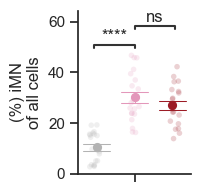

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

mCh-RAS(YBcon)_No ZF, GibCre, vehicle v.s. mCh-RAS(YBcon)_PGK-ZF37-BFP, GibCre, vehicle: t-test independent samples, P_val=3.437e-13 stat=-1.061e+01
mCh-RAS(YBcon)_PGK-ZF37-BFP, GibCre, vehicle v.s. mCh-RAS(YBcon)_PGK-ZF37-BFP, GibCre, +Gib: t-test independent samples, P_val=1.724e-01 stat=1.389e+00


<Figure size 640x480 with 0 Axes>

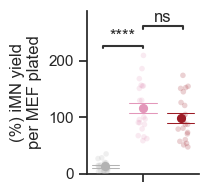

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

mCh-RAS(YBcon)_No ZF, GibCre, vehicle v.s. mCh-RAS(YBcon)_PGK-ZF37-BFP, GibCre, vehicle: t-test independent samples, P_val=8.296e-30 stat=-3.141e+01
mCh-RAS(YBcon)_PGK-ZF37-BFP, GibCre, vehicle v.s. mCh-RAS(YBcon)_PGK-ZF37-BFP, GibCre, +Gib: t-test independent samples, P_val=4.106e-01 stat=8.315e-01


<Figure size 640x480 with 0 Axes>

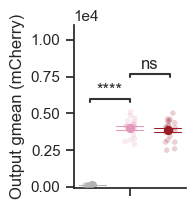

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

mCh-RAS(YBcon)_No ZF, GibCre, vehicle v.s. mCh-RAS(YBcon)_PGK-ZF37-BFP, GibCre, vehicle: t-test independent samples, P_val=2.244e-27 stat=-2.713e+01
mCh-RAS(YBcon)_PGK-ZF37-BFP, GibCre, vehicle v.s. mCh-RAS(YBcon)_PGK-ZF37-BFP, GibCre, +Gib: t-test independent samples, P_val=2.677e-01 stat=1.124e+00


<Figure size 640x480 with 0 Axes>

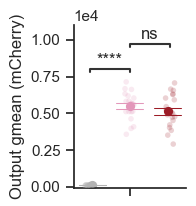

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

mCh-RAS(YBTATA, 380bp)_No ZF, GibCre, vehicle v.s. mCh-RAS(YBTATA, 380bp)_PGK-ZF37-BFP, GibCre, vehicle: t-test independent samples, P_val=7.259e-13 stat=-1.034e+01
mCh-RAS(YBTATA, 380bp)_PGK-ZF37-BFP, GibCre, vehicle v.s. mCh-RAS(YBTATA, 380bp)_PGK-ZF37-BFP, GibCre, +Gib: t-test independent samples, P_val=2.880e-05 stat=-4.720e+00


<Figure size 640x480 with 0 Axes>

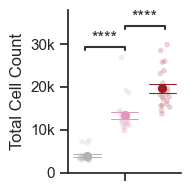

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

mCh-RAS(YBTATA, 380bp)_No ZF, GibCre, vehicle v.s. mCh-RAS(YBTATA, 380bp)_PGK-ZF37-BFP, GibCre, vehicle: t-test independent samples, P_val=1.510e-01 stat=-1.464e+00
mCh-RAS(YBTATA, 380bp)_PGK-ZF37-BFP, GibCre, vehicle v.s. mCh-RAS(YBTATA, 380bp)_PGK-ZF37-BFP, GibCre, +Gib: t-test independent samples, P_val=3.025e-03 stat=-3.157e+00


<Figure size 640x480 with 0 Axes>

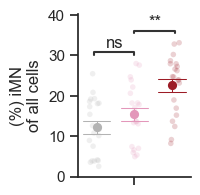

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

mCh-RAS(YBTATA, 380bp)_No ZF, GibCre, vehicle v.s. mCh-RAS(YBTATA, 380bp)_PGK-ZF37-BFP, GibCre, vehicle: t-test independent samples, P_val=2.183e-06 stat=-5.527e+00
mCh-RAS(YBTATA, 380bp)_PGK-ZF37-BFP, GibCre, vehicle v.s. mCh-RAS(YBTATA, 380bp)_PGK-ZF37-BFP, GibCre, +Gib: t-test independent samples, P_val=2.355e-05 stat=-4.783e+00


<Figure size 640x480 with 0 Axes>

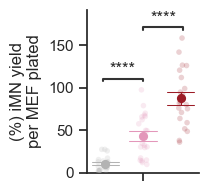

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

mCh-RAS(YBTATA, 380bp)_No ZF, GibCre, vehicle v.s. mCh-RAS(YBTATA, 380bp)_PGK-ZF37-BFP, GibCre, vehicle: t-test independent samples, P_val=1.383e-29 stat=-3.100e+01
mCh-RAS(YBTATA, 380bp)_PGK-ZF37-BFP, GibCre, vehicle v.s. mCh-RAS(YBTATA, 380bp)_PGK-ZF37-BFP, GibCre, +Gib: t-test independent samples, P_val=4.385e-23 stat=-2.083e+01


<Figure size 640x480 with 0 Axes>

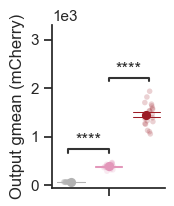

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

mCh-RAS(YBTATA, 380bp)_No ZF, GibCre, vehicle v.s. mCh-RAS(YBTATA, 380bp)_PGK-ZF37-BFP, GibCre, vehicle: t-test independent samples, P_val=1.629e-23 stat=-2.140e+01
mCh-RAS(YBTATA, 380bp)_PGK-ZF37-BFP, GibCre, vehicle v.s. mCh-RAS(YBTATA, 380bp)_PGK-ZF37-BFP, GibCre, +Gib: t-test independent samples, P_val=9.071e-23 stat=-2.042e+01


<Figure size 640x480 with 0 Axes>

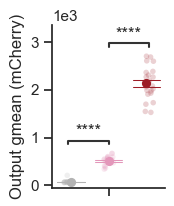

<Figure size 640x480 with 0 Axes>

In [19]:
# GibCre results, mCh-RAS
bar2plot = ['Total Cell Count','(%) iMN\nof all cells','(%) iMN yield\nper MEF plated']
dot2plot = ['mCherry MFI','mCherry MFI (iMNs)']
order = ['mCh-RAS(YBcon)','mCh-RAS(YBTATA, 380bp)']#,'mCh-RAS(YBTATA, 610bp)']
hue_order = ['No ZF, GibCre, vehicle','PGK-ZF37-BFP, GibCre, vehicle','PGK-ZF37-BFP, GibCre, +Gib',]
palette = { 'No ZF, GibCre, vehicle':'#b3b3b3', 'PGK-ZF37-BFP, GibCre, vehicle':'#E397BA', 'PGK-ZF37-BFP, GibCre, +Gib':'#9C1C26'}

pairs = [(('mCh-RAS(YBcon)', 'PGK-ZF37-BFP, GibCre, vehicle'),('mCh-RAS(YBcon)','PGK-ZF37-BFP, GibCre, +Gib')),
          (('mCh-RAS(YBTATA, 380bp)', 'PGK-ZF37-BFP, GibCre, vehicle'),('mCh-RAS(YBTATA, 380bp)','PGK-ZF37-BFP, GibCre, +Gib')),
          (('mCh-RAS(YBTATA, 610bp)', 'PGK-ZF37-BFP, GibCre, vehicle'),('mCh-RAS(YBTATA, 610bp)','PGK-ZF37-BFP, GibCre, +Gib'))]

MFI_ylim_GibCre = {'mCh-RAS(YBcon)':[-50,1.1*10**4],'mCh-RAS(YBTATA, 380bp)':[-50,3.3*10**3],'mCh-RAS(YBTATA, 610bp)':[-50,1.5*10**3]}


for reporter in order:
    pairs = [((reporter, 'No ZF, GibCre, vehicle'),(reporter,'PGK-ZF37-BFP, GibCre, vehicle')),
             ((reporter, 'PGK-ZF37-BFP, GibCre, vehicle'),(reporter,'PGK-ZF37-BFP, GibCre, +Gib'))]
    for y in bar2plot:
        slice = summary_df[(summary_df['reporter']==reporter) & (summary_df['ZF'].isin(['No ZF','PGK-ZF37-BFP'])) & (summary_df['gib'].isin(['vehicle','+Gib']))]
        savetitle = '14dpi_GibCre_' + savedict[reporter] + '_' + savedict[y]
        # custom_barplot('reporter',y,slice,savetitle,
        #                 hue = 'ZF, cre, gib',
        #                 hue_order=hue_order,
        #                 height=2.5,
        #                 width=2,
        #                 order=[reporter],
        #                 palette=palette,reps='rep',xlabel_rot=0,
        #                 pairs=pairs,subfolder='14dpi_all_reps',
        #                 legend=False,xticklabels=False)
        SK_dotplot(x='reporter',y=y,hue='ZF, cre, gib',data=slice,
                   pairs=pairs,palette=palette,order=[reporter],hue_order=hue_order,
                   savetitle=savetitle,save_fig=True,figsize=[1.5,2.5],xlabel=None,subfolder='14dpi_all_reps',
                   legend=False,xticklabels=False,y_ax_k=True,scientific=False,ylim=[0,None])

    for y in dot2plot:
        slice = summary_df[(summary_df['reporter']==reporter) & (summary_df.ZF.isin(['No ZF','PGK-ZF37-BFP'])) & (summary_df['gib'].isin(['vehicle','+Gib']))]
        savetitle = '14dpi_GibCre_' + savedict[reporter] + '_' + savedict[y]
        # custom_catplot('reporter',y,slice,savetitle,
        #                 plottitle=plottitle,
        #                 hue = 'ZF, cre, gib',
        #                 hue_order=hue_order,
        #                 height=2.5,
        #                 width=2,
        #                 order=[reporter],
        #                 palette=palette,log=False,errorbar=False,reps='rep',sci=True,xlabel_rot=0,
        #                 pairs=pairs,size=8)
        SK_dotplot(x='reporter',y=y,hue='ZF, cre, gib',data=slice,
                   pairs=pairs,palette=palette,order=[reporter],hue_order=hue_order,
                   savetitle=savetitle,save_fig=True,figsize=[1.5,2.5],xlabel=None,subfolder='14dpi_all_reps',
                   legend=False,xticklabels=False,ylabel=ylabel_dict[y],ylim=MFI_ylim_GibCre[reporter])



# Calculate Fold Changes

In [20]:
reporters = ['mCh-RAS(YBcon)','mCh-RAS(YBTATA, 380bp)']#,'mCh-RAS(YBTATA, 610bp)']
mod_slice = summary_df[(summary_df['reporter'].isin(reporters)) & (summary_df['ZF'].isin(['No ZF','PGK-ZF37-BFP'])) & (summary_df['gib'] == 'none')]
gib_slice = summary_df[(summary_df['reporter'].isin(reporters)) & (summary_df['ZF'].isin(['No ZF','PGK-ZF37-BFP'])) & (summary_df['gib'].isin(['vehicle','+Gib']))]

# drop all condition columns but 'reporter' and 'ZF, cre' in order to calculate mean of each 'reporter' and 'ZF, cre' conditions across wells and reps
mod_slice = mod_slice.drop(columns=['rep', 'reprogramming', 'ZF', 'cre', 'gib', 'well',
                                    'condition_all', 'cre, gib', 'ZF, cre, gib',
                                    'reporter, ZF, cre, gib', 'reporter, ZF, cre'])

# drop all condition columns but 'reporter' and 'ZF, cre, gib' in order to calculate mean of each 'reporter' and 'ZF, cre, gib' conditions across wells and reps
gib_slice = gib_slice.drop(columns=['rep', 'reprogramming', 'ZF', 'cre', 'gib', 'well',
                                    'condition_all', 'cre, gib', 'ZF, cre',
                                    'reporter, ZF, cre, gib', 'reporter, ZF, cre'])

# Find the mean and standard error of the mean (SEM) for all technical and biological replicates in a given condition:
mod_means = mod_slice.groupby(['reporter','ZF, cre']).mean()
mod_means.reset_index(drop=False,inplace=True) # Remove index

gib_means = gib_slice.groupby(['reporter','ZF, cre, gib']).mean()
gib_means.reset_index(drop=False,inplace=True) # Remove index

for reporter in reporters:
    mod_norm_row = mod_means[(mod_means.reporter == reporter) & (mod_means['ZF, cre'] == 'PGK-ZF37-BFP, modeeBxb1')]
    gib_norm_row = gib_means[(gib_means.reporter == reporter) & (gib_means['ZF, cre, gib'] == 'PGK-ZF37-BFP, GibCre, vehicle')]
    for i in ['(%) iMN yield\nper MEF plated','(%) iMN\nof all cells','mCherry MFI','mCherry MFI (iMNs)']:
        mod_means.loc[(mod_means.reporter == reporter),i+' Fold Change'] = mod_means.loc[
                        (mod_means.reporter == reporter),i] / mod_norm_row[i].values[0]
        gib_means.loc[(gib_means.reporter == reporter),i+' Fold Change'] = gib_means.loc[
                        (gib_means.reporter == reporter),i] / gib_norm_row[i].values[0]
    

mod_means.to_csv(outputdir/'14dpi_modRNA_foldX_all_reps.csv', index=False)
gib_means.to_csv(outputdir/'14dpi_GibCre_foldX_all_reps.csv', index=False)


# Plot mCherry MFI with different GFP gating

First modify summary_df

In [21]:
columns2keep = ['rep', 'reprogramming', 'reporter', 'ZF', 'cre', 'gib', 'well',
                'ZF, cre', 'ZF, cre, gib']

c = columns2keep + ['mCherry MFI (iMNs)']
summary_df_iMNs = summary_df[c].copy()
summary_df_iMNs['GFP Gate'] = 'iMNs'
summary_df_iMNs=summary_df_iMNs.rename(columns={'mCherry MFI (iMNs)': 'mCherry MFI'})

c = columns2keep + ['mCherry MFI (GFP-neg)']
summary_df_GFP_neg = summary_df[c].copy()
summary_df_GFP_neg['GFP Gate'] = 'GFP-neg'
summary_df_GFP_neg=summary_df_GFP_neg.rename(columns={'mCherry MFI (GFP-neg)': 'mCherry MFI'})

c = columns2keep + ['mCherry MFI']
summary_df_all_cells = summary_df[c].copy()
summary_df_all_cells['GFP Gate'] = 'All cells'

summary_df_v2 = pd.concat([summary_df_all_cells,summary_df_iMNs,summary_df_GFP_neg])


In [22]:
summary_df_v2.columns

Index(['rep', 'reprogramming', 'reporter', 'ZF', 'cre', 'gib', 'well',
       'ZF, cre', 'ZF, cre, gib', 'mCherry MFI', 'GFP Gate'],
      dtype='object')

In [23]:
summary_df_v2

,rep,reprogramming,reporter,ZF,cre,gib,well,"ZF, cre","ZF, cre, gib",mCherry MFI,GFP Gate
0,2025.03.24,NIL SDD,"mCh-RAS(YBTATA, 380bp)",No ZF,GibCre,+Gib,D1,"No ZF, GibCre","No ZF, GibCre, +Gib",58.330698,All cells
1,2025.03.24,NIL SDD,"mCh-RAS(YBTATA, 380bp)",No ZF,GibCre,+Gib,D2,"No ZF, GibCre","No ZF, GibCre, +Gib",59.720096,All cells
2,2025.03.24,NIL SDD,"mCh-RAS(YBTATA, 380bp)",No ZF,GibCre,+Gib,D3,"No ZF, GibCre","No ZF, GibCre, +Gib",55.675151,All cells
3,2025.03.24,NIL SDD,"mCh-RAS(YBTATA, 380bp)",No ZF,GibCre,vehicle,C1,"No ZF, GibCre","No ZF, GibCre, vehicle",58.959091,All cells
4,2025.03.24,NIL SDD,"mCh-RAS(YBTATA, 380bp)",No ZF,GibCre,vehicle,C2,"No ZF, GibCre","No ZF, GibCre, vehicle",59.614036,All cells
...,...,...,...,...,...,...,...,...,...,...,...
499,2025.05.12_B,LNI SDD,mCh-RAS(YBcon),PGK-ZF37-BFP,modeeBxb1,none,C3,"PGK-ZF37-BFP, modeeBxb1","PGK-ZF37-BFP, modeeBxb1, none",2081.069529,GFP-neg
500,2025.05.12_B,LNI SDD,mCh-RAS(YBcon),PGK-ZF37-BFP,modeeBxb1,none,D3,"PGK-ZF37-BFP, modeeBxb1","PGK-ZF37-BFP, modeeBxb1, none",2254.468988,GFP-neg
501,2025.05.12_B,LNI SDD,mCh-RAS(YBcon),PGK-ZF37-BFP,modeeBxb1,none,E3,"PGK-ZF37-BFP, modeeBxb1","PGK-ZF37-BFP, modeeBxb1, none",2094.060133,GFP-neg
502,2025.05.12_B,LNI SDD,mCh-RAS(YBcon),PGK-ZF37-BFP,modeeBxb1,none,F3,"PGK-ZF37-BFP, modeeBxb1","PGK-ZF37-BFP, modeeBxb1, none",2150.541274,GFP-neg


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PGK-ZF37-BFP, modeeBxb1_iMNs v.s. PGK-ZF37-BFP, modeeBxb1_GFP-neg: t-test independent samples, P_val=1.759e-04 stat=4.211e+00
PGK-ZF37-BFP, modPuroCre_All cells v.s. PGK-ZF37-BFP, modPuroCre_iMNs: t-test independent samples, P_val=5.185e-03 stat=-2.988e+00
PGK-ZF37-BFP, modPuroCre_iMNs v.s. PGK-ZF37-BFP, modPuroCre_GFP-neg: t-test independent samples, P_val=1.397e-04 stat=4.291e+00
No ZF, NoCre_All cells v.s. No ZF, NoCre_iMNs: t-test independent samples, P_val=3.236e-01 stat=-1.002e+00
No ZF, NoCre_iMNs v.s. No ZF, NoCre_GFP-neg: t-test independent samples, P_val=2.640e-01 stat=1.136e+00
PGK-ZF37-BFP, modeeBxb1_All cells v.s. PGK-ZF37-BFP, modeeBxb1_iMNs: t-test independent samples, P_val=8.178e-03 stat=-2.809e+00


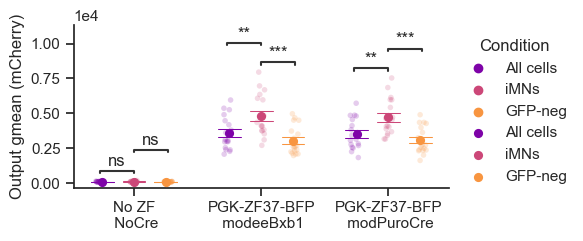

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PGK-ZF37-BFP, modeeBxb1_iMNs v.s. PGK-ZF37-BFP, modeeBxb1_GFP-neg: t-test independent samples, P_val=2.663e-02 stat=2.317e+00
PGK-ZF37-BFP, modPuroCre_All cells v.s. PGK-ZF37-BFP, modPuroCre_iMNs: t-test independent samples, P_val=9.921e-03 stat=-2.732e+00
PGK-ZF37-BFP, modPuroCre_iMNs v.s. PGK-ZF37-BFP, modPuroCre_GFP-neg: t-test independent samples, P_val=1.235e-03 stat=3.524e+00
No ZF, NoCre_All cells v.s. No ZF, NoCre_iMNs: t-test independent samples, P_val=2.731e-01 stat=1.114e+00
No ZF, NoCre_iMNs v.s. No ZF, NoCre_GFP-neg: t-test independent samples, P_val=4.522e-01 stat=-7.605e-01
PGK-ZF37-BFP, modeeBxb1_All cells v.s. PGK-ZF37-BFP, modeeBxb1_iMNs: t-test independent samples, P_val=6.772e-02 stat=-1.887e+00


<Figure size 640x480 with 0 Axes>

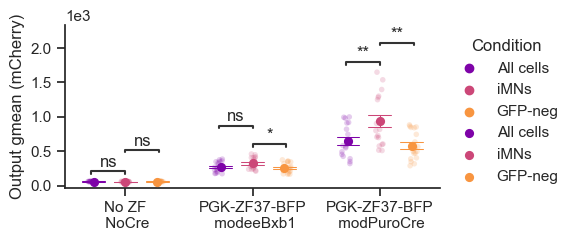

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PGK-ZF37-BFP, modeeBxb1_iMNs v.s. PGK-ZF37-BFP, modeeBxb1_GFP-neg: t-test independent samples, P_val=5.413e-05 stat=4.989e+00
PGK-ZF37-BFP, modPuroCre_All cells v.s. PGK-ZF37-BFP, modPuroCre_iMNs: t-test independent samples, P_val=1.439e-04 stat=-4.587e+00
PGK-ZF37-BFP, modPuroCre_iMNs v.s. PGK-ZF37-BFP, modPuroCre_GFP-neg: t-test independent samples, P_val=5.905e-06 stat=5.918e+00
No ZF, NoCre_All cells v.s. No ZF, NoCre_iMNs: t-test independent samples, P_val=6.981e-01 stat=-3.930e-01
No ZF, NoCre_iMNs v.s. No ZF, NoCre_GFP-neg: t-test independent samples, P_val=2.635e-01 stat=1.148e+00
PGK-ZF37-BFP, modeeBxb1_All cells v.s. PGK-ZF37-BFP, modeeBxb1_iMNs: t-test independent samples, P_val=4.683e-04 stat=-4.104e+00


<Figure size 640x480 with 0 Axes>

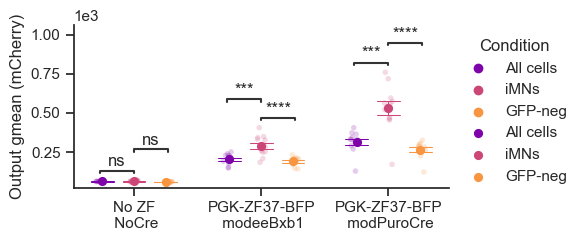

<Figure size 640x480 with 0 Axes>

In [32]:
# modRNA results, mCh-RAS
reporter_list = ['mCh-RAS(YBcon)','mCh-RAS(YBTATA, 380bp)','mCh-RAS(YBTATA, 610bp)']
order = ['No ZF, NoCre','PGK-ZF37-BFP, modeeBxb1','PGK-ZF37-BFP, modPuroCre'] # ZF, cre
hue_order = ['All cells','iMNs','GFP-neg'] # GFP Gate
palette = { 'No ZF, NoCre':'#b3b3b3', 'PGK-ZF37-BFP, modeeBxb1':'#E397BA', 'PGK-ZF37-BFP, modPuroCre':'#9C1C26'}
pairs = [(('No ZF, NoCre','All cells'),('No ZF, NoCre','iMNs')),
         (('No ZF, NoCre','GFP-neg'),('No ZF, NoCre','iMNs')),
         (('PGK-ZF37-BFP, modeeBxb1','All cells'),('PGK-ZF37-BFP, modeeBxb1','iMNs')),
         (('PGK-ZF37-BFP, modeeBxb1','GFP-neg'),('PGK-ZF37-BFP, modeeBxb1','iMNs')),
         (('PGK-ZF37-BFP, modPuroCre','All cells'),('PGK-ZF37-BFP, modPuroCre','iMNs')),
         (('PGK-ZF37-BFP, modPuroCre','GFP-neg'),('PGK-ZF37-BFP, modPuroCre','iMNs'))]

for reporter in reporter_list:
    slice = summary_df_v2[(summary_df_v2['reporter']==reporter) & (summary_df_v2['ZF, cre'].isin(order)) & (summary_df_v2['gib'] == 'none')]
    savetitle = '14dpi_modRNA_' + savedict[reporter] + '_mCherry MFI across GFP gates'
    SK_dotplot(x='ZF, cre',y='mCherry MFI',hue='GFP Gate',data=slice,
                palette='plasma',order=order,hue_order=hue_order,
                savetitle=savetitle,save_fig=True,figsize=[5,2.5],xlabel=None,subfolder='14dpi_all_reps',
                legend=True,xticklabels=True,ylabel='Output gmean (mCherry)',pairs=pairs)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PGK-ZF37-BFP, GibCre, vehicle_iMNs v.s. PGK-ZF37-BFP, GibCre, vehicle_GFP-neg: t-test independent samples, P_val=5.989e-11 stat=8.839e+00
PGK-ZF37-BFP, GibCre, +Gib_All cells v.s. PGK-ZF37-BFP, GibCre, +Gib_iMNs: t-test independent samples, P_val=4.613e-05 stat=-4.570e+00
PGK-ZF37-BFP, GibCre, +Gib_iMNs v.s. PGK-ZF37-BFP, GibCre, +Gib_GFP-neg: t-test independent samples, P_val=2.297e-07 stat=6.223e+00
No ZF, GibCre, vehicle_All cells v.s. No ZF, GibCre, vehicle_iMNs: t-test independent samples, P_val=2.919e-02 stat=-2.262e+00
No ZF, GibCre, vehicle_iMNs v.s. No ZF, GibCre, vehicle_GFP-neg: t-test independent samples, P_val=1.909e-02 stat=2.443e+00
PGK-ZF37-BFP, GibCre, vehicle_All cells v.s. PGK-ZF37-BFP, GibCre, vehicle_iMNs: t-test independent samples, P_val=1.582e-07 stat=-6.338e+00


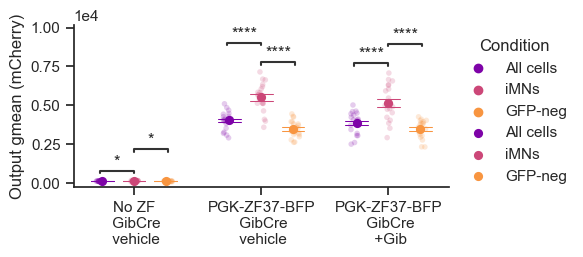

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PGK-ZF37-BFP, GibCre, vehicle_iMNs v.s. PGK-ZF37-BFP, GibCre, vehicle_GFP-neg: t-test independent samples, P_val=2.380e-08 stat=6.926e+00
PGK-ZF37-BFP, GibCre, +Gib_All cells v.s. PGK-ZF37-BFP, GibCre, +Gib_iMNs: t-test independent samples, P_val=4.927e-09 stat=-7.419e+00
PGK-ZF37-BFP, GibCre, +Gib_iMNs v.s. PGK-ZF37-BFP, GibCre, +Gib_GFP-neg: t-test independent samples, P_val=2.249e-11 stat=9.164e+00
No ZF, GibCre, vehicle_All cells v.s. No ZF, GibCre, vehicle_iMNs: t-test independent samples, P_val=4.995e-01 stat=-6.814e-01
No ZF, GibCre, vehicle_iMNs v.s. No ZF, GibCre, vehicle_GFP-neg: t-test independent samples, P_val=4.890e-01 stat=6.983e-01
PGK-ZF37-BFP, GibCre, vehicle_All cells v.s. PGK-ZF37-BFP, GibCre, vehicle_iMNs: t-test independent samples, P_val=9.886e-07 stat=-5.772e+00


<Figure size 640x480 with 0 Axes>

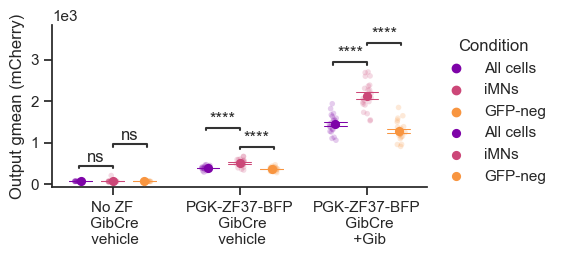

<Figure size 640x480 with 0 Axes>

In [ ]:
# modRNA results, mCh-RAS
reporter_list = ['mCh-RAS(YBcon)','mCh-RAS(YBTATA, 380bp)']#,'mCh-RAS(YBTATA, 610bp)']
order = ['No ZF, GibCre, vehicle','PGK-ZF37-BFP, GibCre, vehicle','PGK-ZF37-BFP, GibCre, +Gib'] # ZF, cre
hue_order = ['All cells','iMNs','GFP-neg'] # GFP Gate
palette = { 'No ZF, GibCre, vehicle':'#b3b3b3', 'PGK-ZF37-BFP, GibCre, vehicle':'#E397BA', 'PGK-ZF37-BFP, GibCre, +Gib':'#9C1C26'}
pairs = [(('No ZF, GibCre, vehicle','All cells'),('No ZF, GibCre, vehicle','iMNs')),
         (('No ZF, GibCre, vehicle','GFP-neg'),('No ZF, GibCre, vehicle','iMNs')),
         (('PGK-ZF37-BFP, GibCre, vehicle','All cells'),('PGK-ZF37-BFP, GibCre, vehicle','iMNs')),
         (('PGK-ZF37-BFP, GibCre, vehicle','GFP-neg'),('PGK-ZF37-BFP, GibCre, vehicle','iMNs')),
         (('PGK-ZF37-BFP, GibCre, +Gib','All cells'),('PGK-ZF37-BFP, GibCre, +Gib','iMNs')),
         (('PGK-ZF37-BFP, GibCre, +Gib','GFP-neg'),('PGK-ZF37-BFP, GibCre, +Gib','iMNs'))]

for reporter in reporter_list:
    slice = summary_df_v2[(summary_df_v2['reporter']==reporter) & (summary_df_v2['ZF, cre, gib'].isin(order)) & (summary_df_v2['gib'] != 'none')]
    savetitle = '14dpi_GibCre_' + savedict[reporter] + '_mCherry MFI across GFP gates'
    SK_dotplot(x='ZF, cre, gib',y='mCherry MFI',hue='GFP Gate',data=slice,
                palette='plasma',order=order,hue_order=hue_order,
                savetitle=savetitle,save_fig=True,figsize=[5,2.5],xlabel=None,subfolder='14dpi_all_reps',
                legend=True,xticklabels=True,ylabel='Output gmean (mCherry)',pairs=pairs)
